In [499]:
import numpy as np
import plotly.express as px
import pandas as pd

def random_risk(t,t0,ysat,alpha,beta):
    t0 = t0 * (1 + np.random.rand() * 0.5 - 0.25)
    ysat = ysat * (1 + np.random.rand() * 0.5 - 0.25)
    alpha = alpha * (1 + np.random.rand() * 0.5 - 0.25)
    beta = beta * (1 + np.random.rand() * 0.5 - 0.25)
    y = ysat * -(np.exp(-alpha * (t - t0)) - np.exp(-beta * (t - t0)))
    y += ysat * -(np.exp(-alpha * (max(t) - (t + t0))) - np.exp(-beta * (max(t) - (t + t0))))
    y[y < 0] = 0
    return y

t = np.linspace(0,12,4320) # 12 hr = 43200 s

df = pd.DataFrame(index=pd.Index(t,name='time'))
for label in [
    'rx-seu','rx-sefi',
    'tx-seu','tx-sefi',
    'gps-seu','gps-sefi',
    'prop-seu','prop-segr',
    'gyro-seu',
    'supply-seu','supply-segr'
]:
    sat = 1e-4
    if label.split('-')[-1] in ['sefi']: sat = 1e-5
    if label.split('-')[-1] in ['segr']: sat = 1e-6
    df[label] = random_risk(t,1,sat,10,0.5)
df.to_csv('input/effects.csv')

px.line(df,labels={'value':'risk (%)','time':'time (hr)','variable':'effect'},log_y=True).show()

In [6]:
def read_sys(file):
    file = str(open(file,'r').read()).split('\n')
    spacer = '    '
    system = {
        'index':range(len(file)),
        'node':[],'level':[],'function':[],'children':[]
    }
    for line in file:
        system['level'].append(len(line.split(spacer)) - 1)
        line = line.replace(spacer,'')
        system['node'].append(line.split(' ')[0])
        system['function'].append([fx.split('(')[0] for fx in line.split(' ')[1:]])
        system['children'].append([fx.split('(')[1].split(')')[0].split(',') for fx in line.split(' ')[1:]])
    return system

In [480]:
def read_sys2(file):
    file = str(open(file,'r').read()).split('\n')
    spacer = '    '
    nodes = {}
    levels = 0
    for line in file:
        if len(line.split(spacer)) > levels: levels = len(line.split(spacer))
        line = line.replace(spacer,'')
        name = line.split()[0]
        functions = [fx.split('(')[0] for fx in line.split(' ')[1:]]
        children = [fx.split('(')[1].split(')')[0].split(',') for fx in line.split(' ')[1:]]
        for fx in functions:
            if fx != 'RISK':
                try: children = [[c[0]] * int(c[1]) for c in children]
                except: pass
        nodes[name] = {'name':name,'function':functions,'children':children}
    system = nodes[file[0].split()[0]]
    sub = [None] * 6
    sub[0] = system['children']
    
    for i in range(len(sub[0])):
        try: sub[0][i] = [nodes[child] for child in sub[0][i]]
        except: continue
        for j in range(len(sub[0][i])):
            sub[1] = sub[0][i][j]['children']

            for i1 in range(len(sub[1])):
                try: sub[1][i1] = [nodes[child] for child in sub[1][i1]]
                except: continue
                for j1 in range(len(sub[1][i1])):
                    sub[2] = sub[1][i1][j1]['children']

                    for i2 in range(len(sub[2])):
                        try: sub[2][i2] = [nodes[child] for child in sub[2][i2]]
                        except: continue
                        for j2 in range(len(sub[2][i2])):
                            sub[3] = sub[2][i2][j2]['children']

                            for i3 in range(len(sub[3])):
                                try: sub[3][i3] = [nodes[child] for child in sub[3][i3]]
                                except: continue
                                for j3 in range(len(sub[3][i3])):
                                    sub[4] = sub[3][i3][j3]['children']

                                    for i4 in range(len(sub[4])):
                                        try: sub[4][i4] = [nodes[child] for child in sub[4][i4]]
                                        except: continue
                                        for j4 in range(len(sub[4][i4])):
                                            sub[5] = sub[4][i4][j4]['children']
        
    return system

print(read_sys2('input/new.sys'))

{'name': 'spacecraft', 'function': ['OR'], 'children': [[{'name': 'comm', 'function': ['OR'], 'children': [[{'name': 'rf', 'function': ['AND'], 'children': [[{'name': 'rx', 'function': ['RISK', 'RISK'], 'children': [['rx-seu', '1'], ['rx-sefi', '60']]}, {'name': 'tx', 'function': ['RISK', 'RISK'], 'children': [['tx-seu', '1'], ['tx-sefi', '60']]}]]}, {'name': 'rf', 'function': ['AND'], 'children': [[{'name': 'rx', 'function': ['RISK', 'RISK'], 'children': [['rx-seu', '1'], ['rx-sefi', '60']]}, {'name': 'tx', 'function': ['RISK', 'RISK'], 'children': [['tx-seu', '1'], ['tx-sefi', '60']]}]]}]]}, {'name': 'nav', 'function': ['OR'], 'children': [[{'name': 'prop', 'function': ['RISK', 'RISK'], 'children': [['prop-seu', '100'], ['prop-segr', 'inf']]}, {'name': 'att', 'function': ['AND'], 'children': [[{'name': 'gyro', 'function': ['RISK'], 'children': [['gyro-seu', '10']]}, {'name': 'gyro', 'function': ['RISK'], 'children': [['gyro-seu', '10']]}]]}, {'name': 'loc', 'function': ['AND'], 'chil

In [7]:
import schemdraw
from schemdraw import Drawing,flow,logic,elements

def fault_tree(system_file):
    tag = system_file.split('/')[-1].split('.')[0]
    system = read_sys(system_file)
    schemdraw.config(inches_per_unit = 1,fontsize=24)
    pos, nodes = {}, system['node'].copy()
    with Drawing(file='output/' + tag + '_diagram.png') as d:
        d.unit = 1
        height = 4
        for i in system['index']:
            if system['function'][i][0] == 'RISK':
                d.here = (d.here[0] + d.unit,-height * d.unit * system['level'][i])
                d += (new := flow.Circle().label(system['node'][i]))
                pos[system['node'][i]] = new.absanchors['N']
                nodes.remove(system['node'][i])
        for level in range(max(system['level']),-1,-1):
            for i in system['index']:
                if system['level'][i] == level and system['node'][i] in nodes:
                    x = [pos[child][0] for child in system['children'][i][0]]
                    d.here = (sum(x) / len(x),-height * d.unit * system['level'][i] * 0.95)
                    d += (new := flow.Terminal().label(system['node'][i]))
                    pos[system['node'][i]] = new.absanchors['N']
                    nodes.remove(system['node'][i])
                    if system['function'][i][0] == 'OR':
                        d += (new := logic.Or(inputs=1).down().reverse())
                    if system['function'][i][0] == 'AND':
                        d += (new := logic.And(inputs=1).down().reverse())
                    for child in system['children'][i][0]:
                        d += elements.Wire('-|').at(new.in1).to(pos[child])

In [8]:
import pandas as pd
import numpy as np

# this should be written in C, fo sho!

def sim(system_file,effects_file,N=1,zombie=False):
    tag = system_file.split('/')[-1].split('.')[0]
    system = read_sys(system_file)
    effects = pd.read_csv('input/effects.csv',index_col='time')
    MISSION = None
    FAILURES = pd.DataFrame(columns=system['node'])
    for n in range(N):
        mission = pd.DataFrame(index=effects.index,columns=system['node'])
        failures = dict([(node,True) for node in system['node']])
        alive = dict([(node,True) for node in system['node']])
        recover = dict([(node,0) for node in system['node']])
        increment = (effects.index[-1] - effects.index[0]) * 3600 / len(effects.index)
        dead = False
        for t in effects.index:
            for i in system['index']:
                if alive[system['node'][i]]:
                    for f in range(len(system['function'][i])):
                        if system['function'][i][f] == 'RISK':
                            rate = effects[system['children'][i][f][0]][t] * increment
                            p = np.exp(-rate) * rate # poisson process
                            if np.random.rand() < p:
                                alive[system['node'][i]] = False
                                recover[system['node'][i]] = t + float(system['children'][i][f][1]) / 3600
                                if float(system['children'][i][f][1]) < 0: recover[system['node'][i]] = np.infty
                if not alive[system['node'][i]] and t >= recover[system['node'][i]]:
                    alive[system['node'][i]] = True
                    recover[system['node'][i]] = 0
            for level in range(max(system['level']),-1,-1):
                for i in system['index']:
                    if system['level'][i] == level:
                        for f in range(len(system['function'][i])):
                            if system['function'][i][f] == 'OR':
                                n = len(system['children'][i][f])
                                alive[system['node'][i]] = sum([alive[child] for child in system['children'][i][f]]) == n
                            if system['function'][i][f] == 'AND': 
                                alive[system['node'][i]] = sum([alive[child] for child in system['children'][i][f]]) > 0
            if not alive[system['node'][0]] and not dead:
                for level in range(0,max(system['level']) + 1):
                    for i in system['index']:
                        if system['level'][i] == level:
                            if failures[system['node'][i]]:
                                if alive[system['node'][i]]:
                                    failures[system['node'][i]] = False
                            if not failures[system['node'][i]]:
                                for f in range(len(system['function'][i])):
                                    if system['function'][i][f] in ['OR','AND']:
                                        for child in system['children'][i][f]: 
                                            failures[child] = False
                dead = True
                if not zombie: break
            mission.loc[t] = alive
        if not dead: failures = dict([(node,False) for node in system['node']])
        mission = mission.fillna(False)
        if MISSION is None: MISSION = mission.astype(float)
        else: MISSION += mission.astype(float)
        FAILURES = FAILURES.append(failures,ignore_index=True)
    FAILURES.index.name = 'n'
    MISSION.to_csv('output/' + tag + '_mission.csv')
    FAILURES.to_csv('output/' + tag + '_failures.csv')
    return MISSION, FAILURES

In [17]:
import plotly.express as px
import pandas as pd

def plot_mission(system_file,mission):
    tag = system_file.split('/')[-1].split('.')[0]
    system = read_sys(system_file)
    fig = px.imshow(mission.values.T,x=mission.index,labels={'x':'time (hr)'},binary_string=True,
    height=100+15*len(system['index']))
    fig.update_yaxes(tickmode='array',tickvals=list(system['index']),ticktext=mission.columns,type='category')
    fig.write_image('output/' + tag + '_mission.png')
    return fig

def plot_failures(system_file,failures):
    tag = system_file.split('/')[-1].split('.')[0]
    system = read_sys(system_file)
    df = pd.DataFrame(system).set_index('index')
    df['failures (%)'] = list(failures.sum() / len(failures))
    df['subsystem'] = ~df['function'].astype(str).str.contains('RISK')
    df = df.sort_values(by='failures (%)',ascending=False)
    fig = px.bar(df,x='node',y='failures (%)',facet_row='subsystem',facet_row_spacing=0.1)
    fig.update_xaxes(matches=None,showticklabels=True)
    fig.write_image('output/' + tag + '_failures.png')
    return fig

estimated time to completion: 45.0 minutes


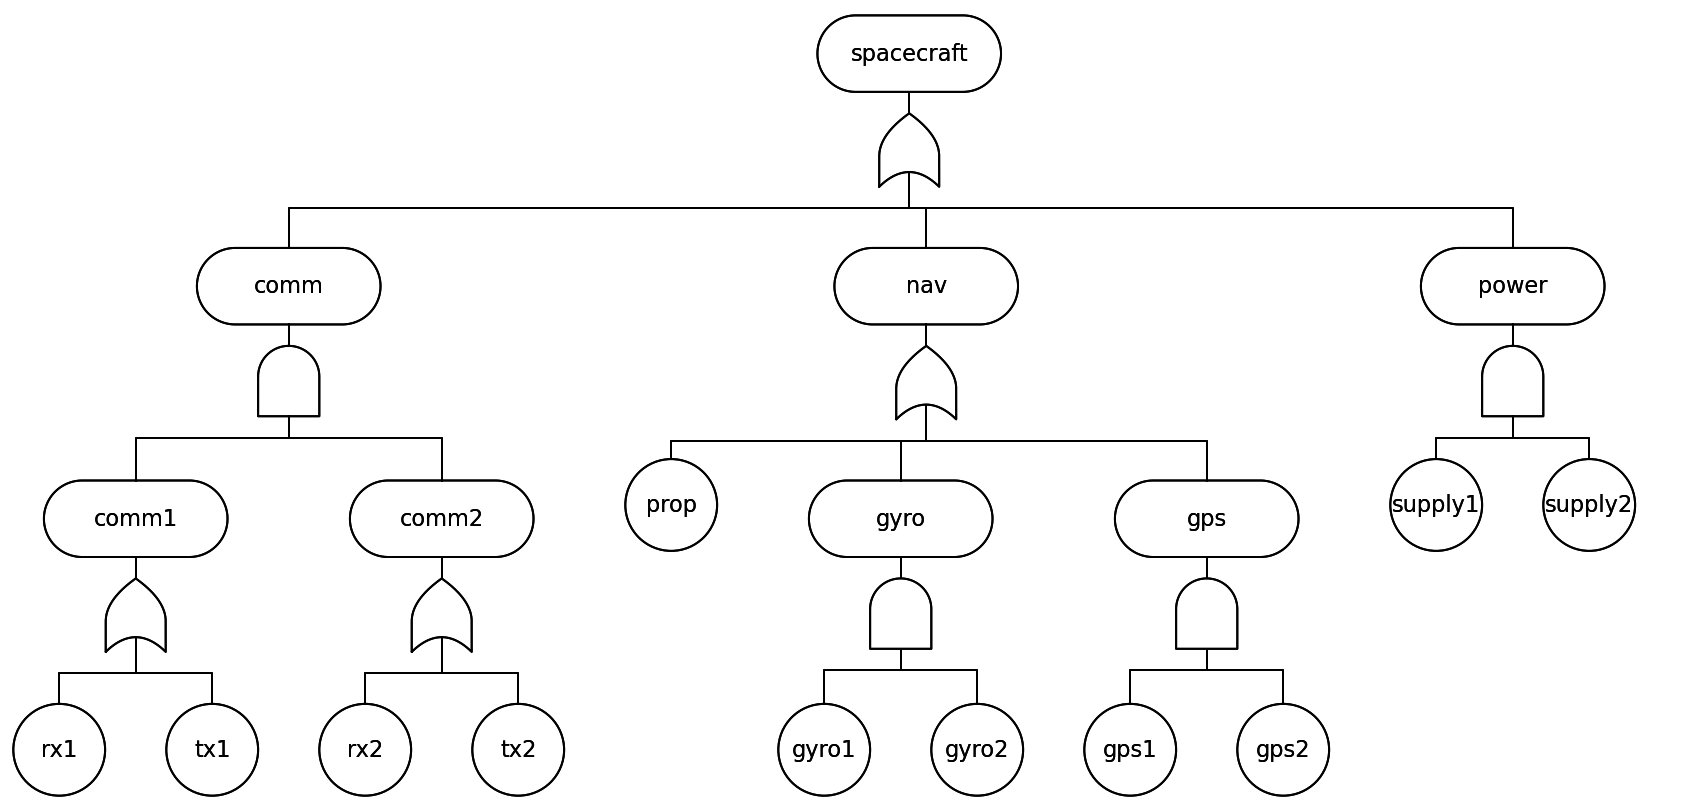

In [23]:
system_file = 'input/spacecraft.sys'
effects_file = 'input/effects.csv'
runs = 1000
print(f'estimated time to completion: {0.045 * runs} minutes')

fault_tree(system_file)
mission,failures = sim(system_file,effects_file,N=runs,zombie=True)
plot_mission(system_file,mission).show()
plot_failures(system_file,failures).show()


estimated time to completion: 45.0 minutes


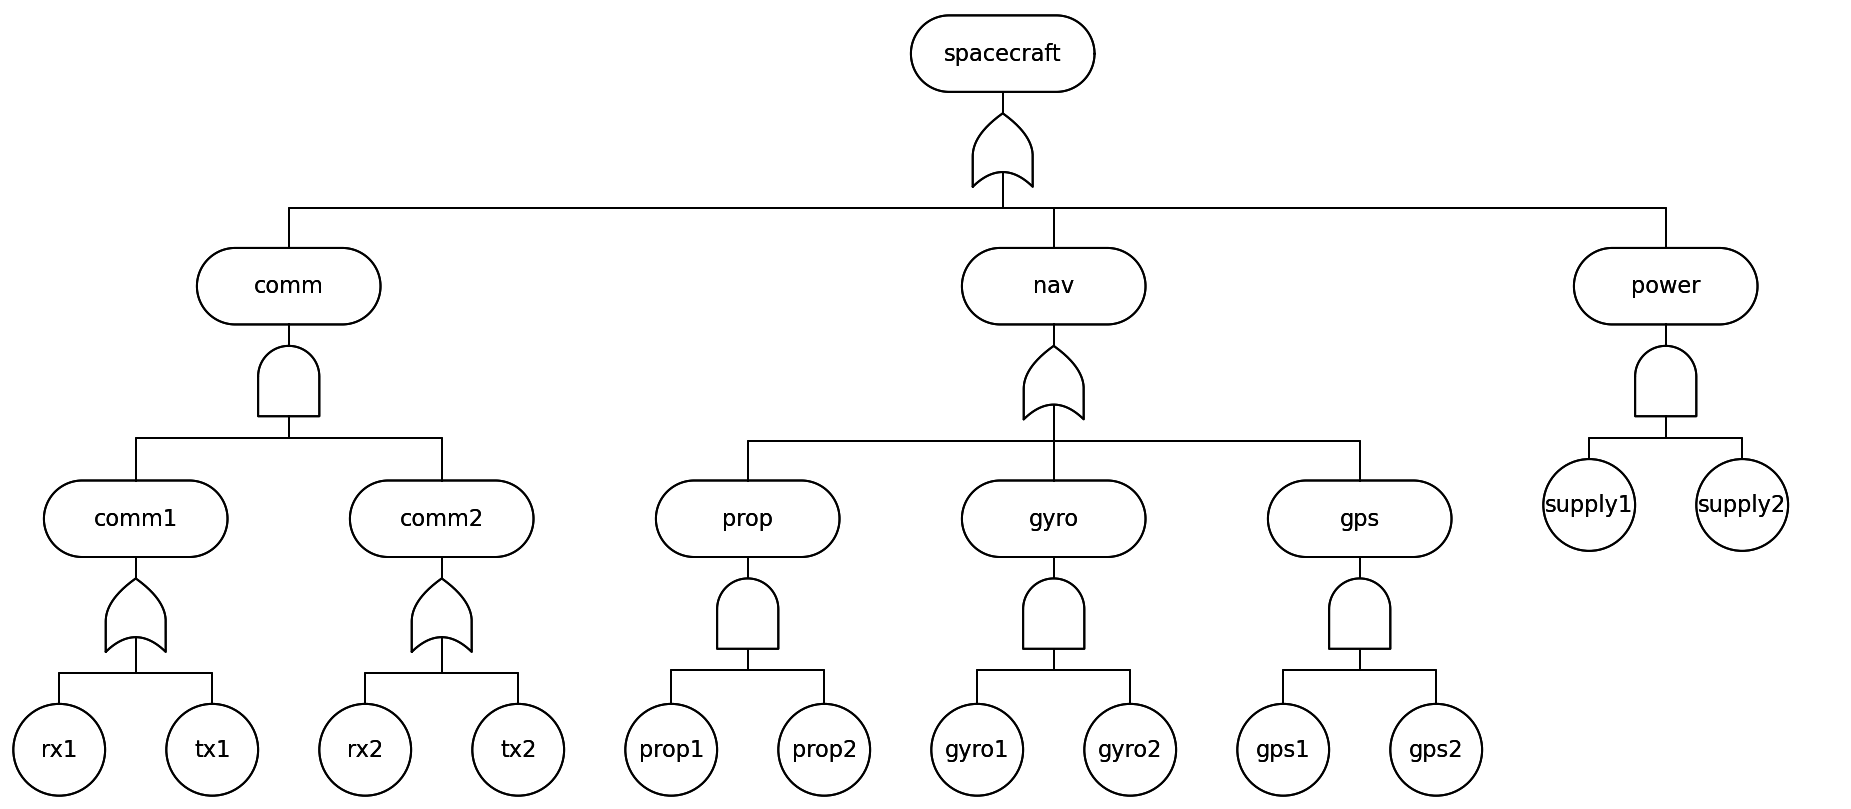

In [24]:
system_file = 'input/upgrade.sys'
effects_file = 'input/effects.csv'
runs = 1000
print(f'estimated time to completion: {0.045 * runs} minutes')

fault_tree(system_file)
mission,failures = sim(system_file,effects_file,N=runs,zombie=True)
plot_mission(system_file,mission).show()
plot_failures(system_file,failures).show()